In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import shap

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [19]:
path = '../data/df_tweetscov19_sample_20000_23_v2.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num', 'Mentions_num', 'URLs_num', 'tweet_political_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (20000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1251062002522324992,1b2c6c119645fd30f59e82204f9fad0c,0,0,1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,4,1.0000,0.4557,True
1,1239315254447935488,93eb5ce04c313422a7d8cd2d2b3645d3,2,23,0,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10,10,1.0000,0.9991,True
2,1221407834660921344,47eedb5b934285524e8268db666cb978,5,35,0,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.6791,True
3,1266679393042092033,02ac4816b30dbb94aae77a22af2b626a,98,286,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.1754,True
4,1256383353726664707,9595b8a5e5a56435a59885ca6b8ea9c0,0,0,0,0,1,0.0000,-1.0000,0.0000,0.0000,-1.0000,0.0000,1,1,1.0000,0.2100,True


In [20]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (20000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1184511338757967879,9b44b8b6c5a9889664d6cd7ce2802e3f,2,4,2,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.7202,False
1,1266906313025617923,65330ebcf5f4eb42bff5d737d4db3b6a,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.7107,True
2,1266393051854966784,71a06fba077c76f2281c8bd4460f8041,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,1,0.3333,0.3792,True
3,1264181154522914818,413ff837abbff8fa8ea64571afcc451d,2,2,0,44,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8,8,1.0000,0.5436,True
4,1242554112685768705,34f1f395fa112af3d3a92e97e421ba5c,0,0,0,41,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4200,False


In [21]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num',
       'Mentions_num', 'URLs_num', 'tweet_political_polarisation',
       'tweet_science_polarisation', 'tweet_moderacy_polarisation',
       'user_political_polarisation', 'user_science_polarisation',
       'user_moderacy_polarisation', 'user_posted_tweets',
       'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation',
       'Is_deleted'],
      dtype='object')

In [22]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)
df_tweetscov19_user.head()

,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1184511338757967879,9b44b8b6c5a9889664d6cd7ce2802e3f,2,4,2,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.7202,0
1,1266906313025617923,65330ebcf5f4eb42bff5d737d4db3b6a,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.7107,1
2,1266393051854966784,71a06fba077c76f2281c8bd4460f8041,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,1,0.3333,0.3792,1
3,1264181154522914818,413ff837abbff8fa8ea64571afcc451d,2,2,0,44,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8,8,1.0000,0.5436,1
4,1242554112685768705,34f1f395fa112af3d3a92e97e421ba5c,0,0,0,41,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4200,0


In [23]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username',  'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio'])

In [2]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [25]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(20000, 12)
(20000,)


In [3]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 12)
(4000, 12)
(16000,)
(4000,)


In [4]:
def fit_random_forest_clf(X,y):

    clf = RandomForestClassifier( n_jobs=-1)
    clf.fit(X,y)
    return clf

In [5]:
def test_random_forest_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [30]:
rf_model = fit_random_forest_clf(X_train, y_train)

In [31]:
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.57925


In [32]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59      2024
           1       0.58      0.56      0.57      1976

    accuracy                           0.58      4000
   macro avg       0.58      0.58      0.58      4000
weighted avg       0.58      0.58      0.58      4000



In [6]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

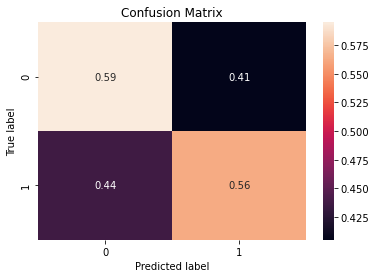

In [34]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

***

In [7]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [36]:
rf_model = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)

rf_model.fit(X_train, y_train)

f_importances = features_classifier_(X_train, rf_model)
f_importances

,index,Feature,importance
0,11,user_Reputation,0.2964
1,8,user_political_polarisation,0.1349
2,10,user_moderacy_polarisation,0.1312
3,0,Retweets,0.0992
4,1,Favorites,0.0918
5,4,URLs_num,0.0798
6,2,Hashtags_num,0.0681
7,3,Mentions_num,0.0447
8,9,user_science_polarisation,0.0234
9,5,tweet_political_polarisation,0.0152


In [37]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_political_polarisation'
 'user_moderacy_polarisation' 'Retweets' 'Favorites' 'URLs_num'
 'Hashtags_num' 'Mentions_num' 'user_science_polarisation'
 'tweet_political_polarisation' 'tweet_moderacy_polarisation']


In [38]:
len(f_importances)

11

In [39]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(20000, 11)
(20000,)


In [24]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [41]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.59 +/- 0.011
 f1        : 0.68 +/- 0.013
 recall    : 0.79 +/- 0.021
Wall time: 24.3 s


In [42]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.60 +/- 0.010
 f1        : 0.68 +/- 0.013
 recall    : 0.79 +/- 0.022
Wall time: 22.1 s


******

***

****

In [43]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ['sqrt', 'log2', 'auto']
max_depth =  [2,4,6,8,10]
min_samples_split = [2,4,8]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [44]:
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
rf_model = RandomForestClassifier()

In [31]:
%%time
clf_grid = GridSearchCV(rf_model, param_grid = param_grid, cv = 3, verbose = 2, n_jobs = -1)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
Wall time: 1h 8min 34s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=2)

In [32]:
clf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 300}

In [33]:
clf_grid.score(X_test,y_test)

0.641

In [34]:
%%time
#20 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.61 +/- 0.009
 f1        : 0.69 +/- 0.012
 recall    : 0.79 +/- 0.019
Wall time: 45.4 s


In [25]:
%%time
#200 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.61 +/- 0.002
 f1        : 0.69 +/- 0.002
 recall    : 0.80 +/- 0.005
Wall time: 6min 43s


***

In [45]:
def plot_hist_Features(l_features_importances, l_features, title):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'peru', 'black', 'mediumslateblue', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
    #plt.legend()
    #plt.savefig('../plots/'+title+'.pdf')


In [46]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

AttributeError: 'numpy.ndarray' object has no attribute 'Feature'

In [47]:
plot_hist_Features(l_features_importances, l_features, 'Rf_tweetscov19_content_User')

NameError: name 'l_features_importances' is not defined

************************************************
************************************************

## TweetsCov19
### (Content only)

In [48]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[  'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [49]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(20000, 8)
(20000,)


In [50]:
X_train, X_test, y_train, y_test= split_train_test_valid(X,y)

(16000, 8)
(4000, 8)
(16000,)
(4000,)


In [51]:
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,0,Retweets,0.2379
1,1,Favorites,0.2320
2,4,URLs_num,0.1841
3,2,Hashtags_num,0.1272
4,3,Mentions_num,0.1049
5,5,tweet_political_polarisation,0.0537
6,7,tweet_moderacy_polarisation,0.0479
7,6,tweet_science_polarisation,0.0122


In [52]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'Favorites' 'URLs_num' 'Hashtags_num' 'Mentions_num'
 'tweet_political_polarisation' 'tweet_moderacy_polarisation'
 'tweet_science_polarisation']


In [53]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(20000, 8)
(20000,)


In [54]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X_new, y)

 percision : 0.59 +/- 0.008
 f1        : 0.63 +/- 0.011
 recall    : 0.69 +/- 0.018
Wall time: 17 s


In [55]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(rf_model, X, y)

 percision : 0.59 +/- 0.009
 f1        : 0.63 +/- 0.011
 recall    : 0.69 +/- 0.018
Wall time: 16.3 s


********************************************************
********************************************************

In [32]:
%%time
#200 000 Tweets

clf_cv = RandomForestClassifier(n_estimators = 300, max_features = 'sqrt',max_depth = 10, min_samples_split = 8, min_samples_leaf=1, bootstrap = True, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)


 percision : 0.60 +/- 0.003
 f1        : 0.66 +/- 0.003
 recall    : 0.72 +/- 0.004
Wall time: 7min 46s


***

## Plot feature Imortances
### TweetCov19 (Content Only)

In [28]:
def plot_hist_Features_content_only(l_features_importances, l_features, title):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['peru', 'black', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=18)
    ax.set_ylabel('Feature Importance', fontsize=20)
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    fig.tight_layout()
    

    #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [29]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Retweets',
 'Favorites',
 'Number of URLs',
 'Text length',
 'I',
 'Number of hashtags',
 'Political polarisation (tweet based)',
 'Informal',
 'Moderacy polarisation (tweet based)',
 'Work']

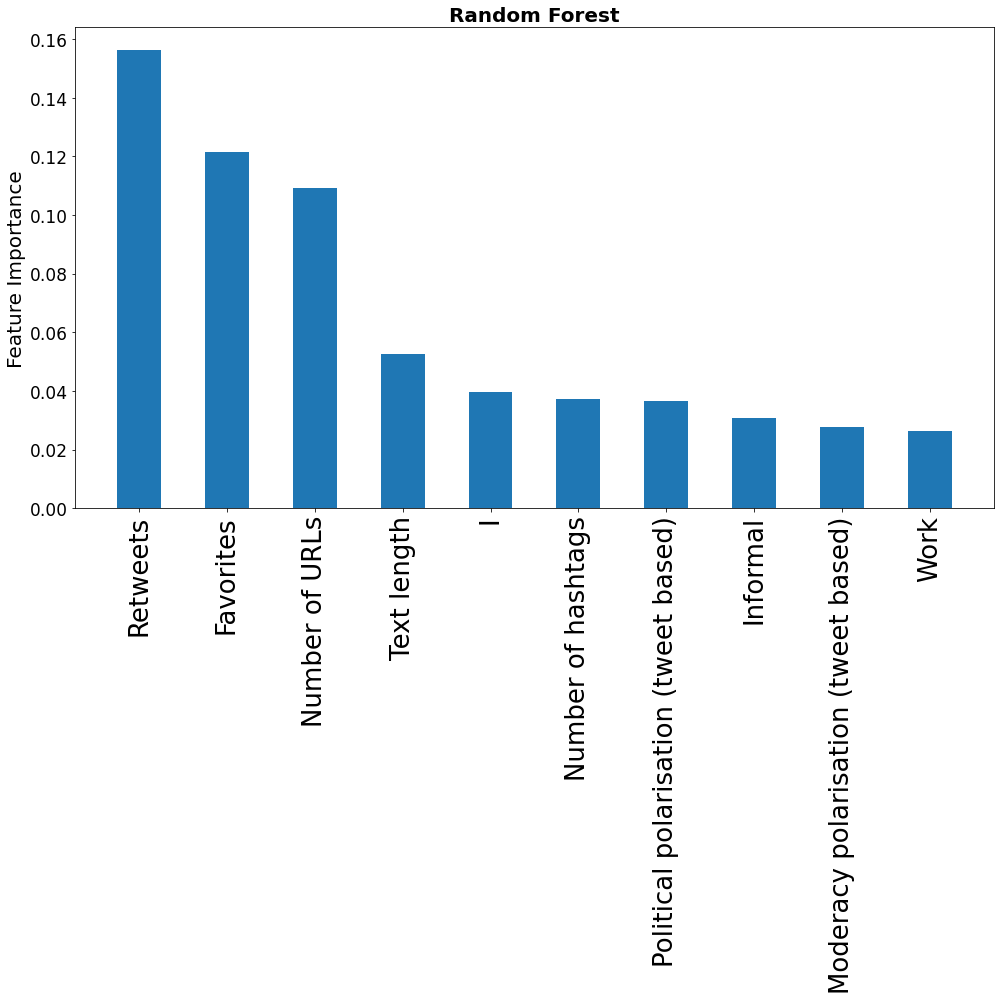

In [30]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Rf_tweetscov19_content_only')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [8]:
path = '../data/df_tweetskb_sample_20000_9_v2.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num', 'Mentions_num', 'URLs_num', 'tweet_political_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted' ])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (20000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1215531172496801792,GingrrGoddess,0,0,7,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7,3,0.4286,0.3011,True
1,1252892958808051712,jerdul3,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.2933,True
2,1256687285598171136,porshiugh_,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.4178,True
3,1224289441319010304,rchlvienne,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.5632,True
4,1221607964043304969,Munisty600,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.7288,True


In [9]:
features = df_tweetskb_user.columns
#features

In [10]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
19995,1214560501507620870,_adventuretz,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.2500,0
19996,1223003794834952194,BarbaraAnn1212,0,0,0,4,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,0,0.0000,0.3312,0
19997,1183941084067577856,DodsonNiagh,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,0,0.0000,0.4756,0
19998,1200293570323894273,sfawcus,1,3,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.3576,0
19999,1266000506956271622,LunaticCODM,1,5,1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.2353,0


In [11]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (20000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1265030154700632070,kaydagoddess_,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.5724,0
1,1230490723960492034,match_latte1216,0,0,1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4000,0
2,1228510291052388352,JenReadsRomance,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15,0,0.0000,0.6259,0
3,1179257808115703809,yoongleselle,0,0,0,3,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.4996,0
4,1221719092110823424,Drew2C,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,0,0.0000,0.4643,0


In [12]:
print(len(features))
features

18


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num',
       'Mentions_num', 'URLs_num', 'tweet_political_polarisation',
       'tweet_science_polarisation', 'tweet_moderacy_polarisation',
       'user_political_polarisation', 'user_science_polarisation',
       'user_moderacy_polarisation', 'user_posted_tweets',
       'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation',
       'Is_deleted'],
      dtype='object')

In [13]:
#df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio',])

In [14]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(20000, 12)
(20000,)


In [15]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 12)
(4000, 12)
(16000,)
(4000,)


In [16]:
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.5415


In [17]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.56      0.54      1941
           1       0.56      0.53      0.54      2059

    accuracy                           0.54      4000
   macro avg       0.54      0.54      0.54      4000
weighted avg       0.54      0.54      0.54      4000



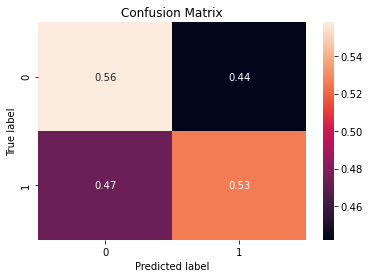

In [18]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [19]:
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,11,user_Reputation,0.3287
1,0,Retweets,0.1476
2,1,Favorites,0.1334
3,3,Mentions_num,0.0824
4,8,user_political_polarisation,0.0767
5,4,URLs_num,0.0747
6,2,Hashtags_num,0.0700
7,10,user_moderacy_polarisation,0.0686
8,5,tweet_political_polarisation,0.0056
9,9,user_science_polarisation,0.0055


In [20]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'Retweets' 'Favorites' 'Mentions_num'
 'user_political_polarisation' 'URLs_num' 'Hashtags_num'
 'user_moderacy_polarisation']


In [21]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(20000, 8)
(20000,)


In [25]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.56 +/- 0.007
 f1        : 0.62 +/- 0.008
 recall    : 0.70 +/- 0.012
Wall time: 24.7 s


In [26]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.56 +/- 0.008
 f1        : 0.62 +/- 0.008
 recall    : 0.70 +/- 0.014
Wall time: 24.1 s


***

In [68]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ['sqrt', 'log2', 'auto']
max_depth =  [2,4,6,8,10]
min_samples_split = [2,4,8]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

In [69]:
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [26]:
rf_model = RandomForestClassifier()

In [70]:
%%time
clf_grid = GridSearchCV(rf_model, param_grid = param_grid, cv = 3, verbose = 10, n_jobs = -1)
clf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
Wall time: 57min 54s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 1000]},
             verbose=10)

In [71]:
clf_grid.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 300}

In [27]:
%%time
#20000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

print_cross_val_score(clf_cv, X_new, y)

 percision : 0.56 +/- 0.008
 f1        : 0.62 +/- 0.008
 recall    : 0.69 +/- 0.015
Wall time: 22.4 s


In [25]:
%%time
#200 000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

print_cross_val_score(clf_cv, X_new, y)

 percision : 0.57 +/- 0.003
 f1        : 0.64 +/- 0.003
 recall    : 0.72 +/- 0.003
Wall time: 8min 46s


*****************************************************
*****************************************************

## Plot feature Imortances
### Tweetkb (Content + User)

In [40]:
def plot_hist_Features_kb(l_features_importances, l_features, title):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue','Black', 'peru', 'mediumslateblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [14,14]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
   #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [41]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Reputation (user)',
 'Retweets',
 'Favorites',
 'Focusfuture',
 'Political polarisation (user based)',
 'Moderacy polarisation (user based)',
 'Text length',
 'Number of URLs',
 'User sentiment average',
 'Informal']

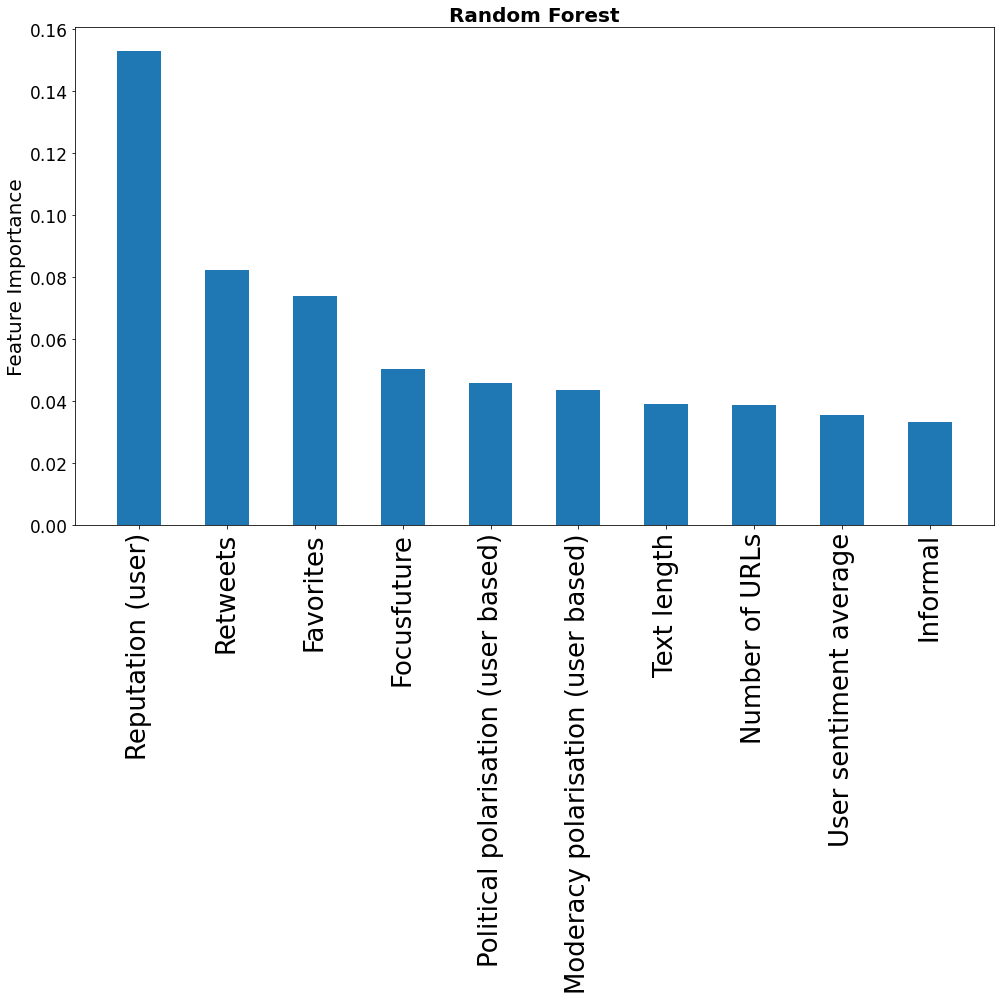

In [42]:
plot_hist_Features_kb(l_features_importances, l_features, 'Rf_tweetskb_content_user')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [89]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[   'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation',])


In [90]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(20000, 8)
(20000,)


In [91]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 8)
(4000, 8)
(16000,)
(4000,)


In [92]:
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
clf_cv.fit(X_train, y_train)

f_importances = features_classifier_(X, clf_cv)
f_importances

,index,Feature,importance
0,0,Retweets,0.3168
1,1,Favorites,0.2895
2,3,Mentions_num,0.1303
3,2,Hashtags_num,0.1186
4,4,URLs_num,0.1021
5,5,tweet_political_polarisation,0.0226
6,7,tweet_moderacy_polarisation,0.0156
7,6,tweet_science_polarisation,0.0047


In [93]:
f_importances = f_importances[f_importances['importance'] > 0.008]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'Favorites' 'Mentions_num' 'Hashtags_num' 'URLs_num'
 'tweet_political_polarisation' 'tweet_moderacy_polarisation']


In [94]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(20000, 7)
(20000,)


In [95]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.55 +/- 0.008
 f1        : 0.62 +/- 0.011
 recall    : 0.71 +/- 0.016
Wall time: 15.9 s


In [96]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.55 +/- 0.008
 f1        : 0.62 +/- 0.010
 recall    : 0.71 +/- 0.014
Wall time: 16.6 s


***************************************************
***************************************************

In [32]:
%%time
#200 000 Tweets
clf_cv = RandomForestClassifier(n_estimators = 300, min_samples_split= 8, min_samples_leaf= 2, max_features= 'auto', max_depth = 10, bootstrap= False, n_jobs=-1)

print_cross_val_score(clf_cv, X_new, y)

 percision : 0.57 +/- 0.003
 f1        : 0.62 +/- 0.002
 recall    : 0.68 +/- 0.004
Wall time: 9min 45s


***

## Plot feature Imortances
### Tweetkb (Content Only )

In [47]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, title):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['black', 'peru', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, width = 0.5)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
 
    #plt.legend()
    plt.savefig('../plots/'+title+'.pdf')


In [48]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:10]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:10]
l_features

['Retweets',
 'Favorites',
 'Focusfuture',
 'Number of URLs',
 'Text length',
 'Informal',
 'Sexual',
 'Number of hashtags',
 'Work',
 'Article']

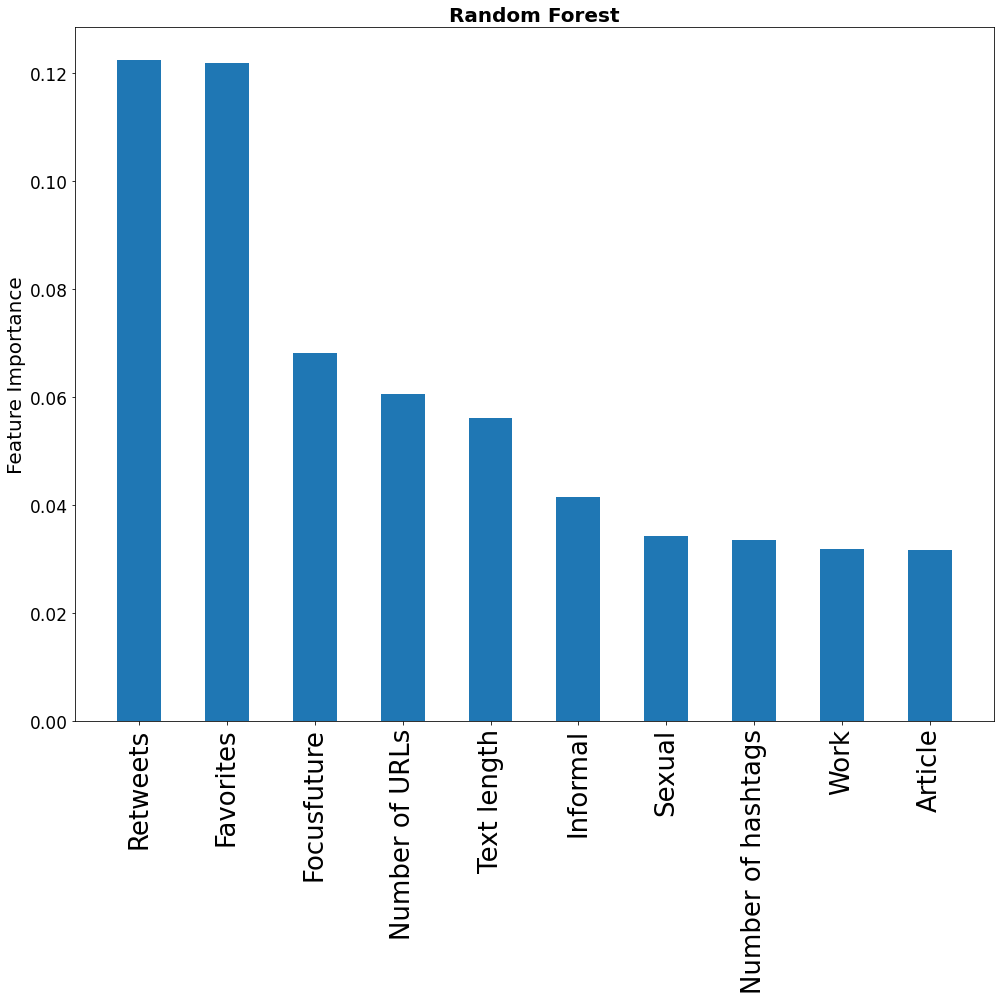

In [49]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Rf_tweetskb_content_only')